In [1]:
import numpy as np
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import xarray as xr
import xgcm
import gsw
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
plt.rcParams['font.size']=14

In [2]:
def fix_dimension(ds, bad_dim, new_dim, trim=True):
    assert len(ds[bad_dim]) == (len(ds[new_dim]) + 1)
    if trim and (len(ds[bad_dim]) == (len(ds[new_dim]) + 1)):
        ds = ds.isel(**{bad_dim: slice(0,-1)})
        assert len(ds[bad_dim]) == len(ds[new_dim])
    swapped_vars = []
    for v in ds:
        # replace naughty dimension
        dims = list(ds[v].dims)
        if bad_dim in dims:
            idx = dims.index(bad_dim)
            dims[idx] = new_dim
            ds[v].variable.dims = dims
            swapped_vars.append(v)
    return ds, swapped_vars

def reset_dimensions(ds, orig_dim, new_dim, *reset_vars):
    for v in reset_vars:
        dims = list(ds[v].dims)
        if new_dim in dims:
            idx = dims.index(new_dim)
            dims[idx] = orig_dim
            ds[v].variable.dims = dims
    # reindexing necessary to figure out new dims
    return ds.reindex()

def open_mncdataset(fname_base, ntiles_y, ntiles_x, iternum=None):
    if iternum is not None:
        itersuf = '.%010d' % iternum
    else:
        itersuf = ''
    dsets_y = []
    for ny in range(ntiles_y):
        dsets_x = []
        swap_vars = set()
        for nx in range(ntiles_x):
            ntile = nx + ntiles_x*ny + 1
            fname = fname_base + '%s.t%03d.nc' % (itersuf, ntile)
            ds = xr.open_dataset(fname)
            ds, swapped_vars_x = fix_dimension(ds, 'Xp1', 'X')    
            ds = ds.chunk()
            dsets_x.append(ds)
        ds_xconcat = xr.concat(dsets_x, 'X')
        ds_xconcat, swapped_vars_y = fix_dimension(ds_xconcat, 'Yp1', 'Y')
        dsets_y.append(ds_xconcat)
    ds = xr.concat(dsets_y, 'Y')
    ds = reset_dimensions(ds, 'Xp1', 'X', *swapped_vars_x)
    ds = reset_dimensions(ds, 'Yp1', 'Y', *swapped_vars_y)
    return ds



In [3]:
dss = open_mncdataset('run_bump5000_barotrop_withoutGM/state', 2, 3, 0)
dsg = open_mncdataset('run_bump5000_barotrop_withoutGM/grid', 2, 3, None)
dsbb=xr.merge((dss,dsg))
dsbb=dsbb.isel(Zp1=slice(0,-1))
dsbb['Z']=-1*dsbb.Z
dsbb['Zl']=-1*dsbb.Zl
dsbb=dsbb.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsbb = xgcm.generate_grid_ds(dsbb, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsbb.coords['day']=dsbb.T/(24*3600)
dsbb.coords['month']=dsbb.day/30

# equal t startification
dss = open_mncdataset('run_bump5000_20layers_withoutGM/state', 2, 3, 0)
dsg = open_mncdataset('run_bump5000_20layers_withoutGM/grid', 2, 3, None)
dsb2u=xr.merge((dss,dsg))
dsb2u=dsb2u.isel(Zp1=slice(0,-1))
dsb2u['Z']=-1*dsb2u.Z
dsb2u['Zl']=-1*dsb2u.Zl
dsb2u=dsb2u.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsb2u = xgcm.generate_grid_ds(dsb2u, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsb2u.coords['day']=dsb2u.T/(24*3600)
dsb2u.coords['month']=dsb2u.day/30


# e-scale stratificiation; thermal wind balanced
dss = open_mncdataset('run_bump5000_tw_withoutGM/state', 2, 3, 0)
dsg = open_mncdataset('run_bump5000_tw_withoutGM/grid', 2, 3, None)
dsbet=xr.merge((dss,dsg))
dsbet=dsbet.isel(Zp1=slice(0,-1))
dsbet['Z']=-1*dsbet.Z
dsbet['Zl']=-1*dsbet.Zl
dsbet=dsbet.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsbet=xgcm.generate_grid_ds(dsbet, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsbet.coords['day']=dsbet.T/(24*3600)
dsbet.coords['month']=dsbet.day/30
# add to thermal wind a barotropic inflow condition
dss = open_mncdataset('run_bump5000_u01tw_withoutGM/state', 2, 3, 0)
dsg = open_mncdataset('run_bump5000_u01tw_withoutGM/grid', 2, 3, None)
dsbetu=xr.merge((dss,dsg))
dsbetu=dsbetu.isel(Zp1=slice(0,-1))
dsbetu['Z']=-1*dsbetu.Z
dsbetu['Zl']=-1*dsbetu.Zl
dsbetu=dsbetu.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsbetu=xgcm.generate_grid_ds(dsbetu, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsbetu.coords['day']=dsbetu.T/(24*3600)
dsbetu.coords['month']=dsbetu.day/30



# e-scale stratificiation; thermal wind balanced
dss = open_mncdataset('run_bump5000_real_tw_withoutGM/state', 2, 3, 0)
dsg = open_mncdataset('run_bump5000_real_tw_withoutGM/grid', 2, 3, None)
dsbrt=xr.merge((dss,dsg))
dsbrt=dsbrt.isel(Zp1=slice(0,-1))
dsbrt['Z']=-1*dsbrt.Z
dsbrt['Zl']=-1*dsbrt.Zl
dsbrt=dsbrt.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsbrt=xgcm.generate_grid_ds(dsbrt, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsbrt.coords['day']=dsbrt.T/(24*3600)
dsbrt.coords['month']=dsbrt.day/30

# add to thermal wind a barotropic inflow condition
dss = open_mncdataset('run_bump5000_real_utw_withoutGM/state', 2, 3, 0)
dsg = open_mncdataset('run_bump5000_real_utw_withoutGM/grid', 2, 3, None)
dsbrtu=xr.merge((dss,dsg))
dsbrtu=dsbrtu.isel(Zp1=slice(0,-1))
dsbrtu['Z']=-1*dsbrtu.Z
dsbrtu['Zl']=-1*dsbrtu.Zl
dsbrtu=dsbrtu.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsbrtu=xgcm.generate_grid_ds(dsbrtu, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsbrtu.coords['day']=dsbrtu.T/(24*3600)
dsbrtu.coords['month']=dsbrtu.day/30



# add meridional gradient to equal stratficiation; thermal wind balanced
dss = open_mncdataset('run_bump5000_20layerswdTdy_tw_withoutGM/state', 2, 3, 0)
dsg = open_mncdataset('run_bump5000_20layerswdTdy_tw_withoutGM/grid', 2, 3, None)
dsb2t=xr.merge((dss,dsg))
dsb2t=dsb2t.isel(Zp1=slice(0,-1))
dsb2t['Z']=-1*dsb2t.Z
dsb2t['Zl']=-1*dsb2t.Zl
dsb2t=dsb2t.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsb2t = xgcm.generate_grid_ds(dsb2t, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsb2t.coords['day']=dsb2t.T/(24*3600)
dsb2t.coords['month']=dsb2t.day/30

# add to thermal wind a barotropic inflow condition
dss = open_mncdataset('run_bump5000_20layerswdTdy_u01tw_withoutGM/state', 2, 3, 0)
dsg = open_mncdataset('run_bump5000_20layerswdTdy_u01tw_withoutGM/grid', 2, 3, None)
dsb2tu010=xr.merge((dss,dsg))
dsb2tu010=dsb2tu010.isel(Zp1=slice(0,-1))
dsb2tu010['Z']=-1*dsb2tu010.Z
dsb2tu010['Zl']=-1*dsb2tu010.Zl
dsb2tu010=dsb2tu010.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsb2tu010=xgcm.generate_grid_ds(dsb2tu010, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsb2tu010.coords['day']=dsb2tu010.T/(24*3600)
dsb2tu010.coords['month']=dsb2tu010.day/30

# add to thermal wind a barotropic inflow condition
dss = open_mncdataset('run_bump5000_20layerswdTdy_u001tw_withoutGM/state', 2, 3, 0)
dsg = open_mncdataset('run_bump5000_20layerswdTdy_u001tw_withoutGM/grid', 2, 3, None)
dsb2tu001=xr.merge((dss,dsg))
dsb2tu001['Z']=-1*dsb2tu001.Z
dsb2tu001['Zl']=-1*dsb2tu001.Zl
dsb2tu001=dsb2tu001.isel(Zp1=slice(0,-1)).rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsb2tu001=xgcm.generate_grid_ds(dsb2tu001, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsb2tu001.coords['day']=dsb2tu001.T/(24*3600)
dsb2tu001.coords['month']=dsb2tu001.day/30

# add to thermal wind a barotropic inflow condition
dss = open_mncdataset('run_bump5000_20layerswdTdy_u002tw_withoutGM/state', 2, 3, 0)
dsg = open_mncdataset('run_bump5000_20layerswdTdy_u002tw_withoutGM//grid', 2, 3, None)
dsb2tu002=xr.merge((dss,dsg))
dsb2tu002['Z']=-1*dsb2tu002.Z
dsb2tu002['Zl']=-1*dsb2tu002.Zl
dsb2tu002=dsb2tu002.isel(Zp1=slice(0,-1)).rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsb2tu002=xgcm.generate_grid_ds(dsb2tu002, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsb2tu002.coords['day']=dsb2tu002.T/(24*3600)
dsb2tu002.coords['month']=dsb2tu002.day/30

# add to thermal wind a barotropic inflow condition
dss = open_mncdataset('run_bump5000_20layerswdTdy_u005tw_withoutGM/state', 2, 3, 0)
dsg = open_mncdataset('run_bump5000_20layerswdTdy_u005tw_withoutGM/grid', 2, 3, None)
dsb2tu005=xr.merge((dss,dsg))
dsb2tu005['Z']=-1*dsb2tu005.Z
dsb2tu005['Zl']=-1*dsb2tu005.Zl
dsb2tu005=dsb2tu005.isel(Zp1=slice(0,-1)).rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsb2tu005=xgcm.generate_grid_ds(dsb2tu005, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsb2tu005.coords['day']=dsb2tu005.T/(24*3600)
dsb2tu005.coords['month']=dsb2tu005.day/30

# add to thermal wind a barotropic inflow condition
dss = open_mncdataset('run_bump5000_20layerswdTdy_u008tw_withoutGM/state', 2, 3, 0)
dsg = open_mncdataset('run_bump5000_20layerswdTdy_u008tw_withoutGM//grid', 2, 3, None)
dsb2tu008=xr.merge((dss,dsg))
dsb2tu008['Z']=-1*dsb2tu008.Z
dsb2tu008['Zl']=-1*dsb2tu008.Zl
dsb2tu008=dsb2tu008.isel(Zp1=slice(0,-1)).rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsb2tu008=xgcm.generate_grid_ds(dsb2tu008, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsb2tu008.coords['day']=dsb2tu008.T/(24*3600)
dsb2tu008.coords['month']=dsb2tu008.day/30

# add to thermal wind a barotropic inflow condition
dss = open_mncdataset('run_bump5000_20layerswdTdy_u012tw_withoutGM/state', 2, 3, 0)
dsg = open_mncdataset('run_bump5000_20layerswdTdy_u012tw_withoutGM//grid', 2, 3, None)
dsb2tu012=xr.merge((dss,dsg))
dsb2tu012['Z']=-1*dsb2tu012.Z
dsb2tu012['Zl']=-1*dsb2tu012.Zl
dsb2tu012=dsb2tu012.isel(Zp1=slice(0,-1)).rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsb2tu012=xgcm.generate_grid_ds(dsb2tu012, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsb2tu012.coords['day']=dsb2tu012.T/(24*3600)
dsb2tu012.coords['month']=dsb2tu012.day/30

# add to thermal wind a barotropic inflow condition
dss = open_mncdataset('run_bump5000_20layerswdTdy_u015tw_withoutGM/state', 2, 3, 0)
dsg = open_mncdataset('run_bump5000_20layerswdTdy_u015tw_withoutGM//grid', 2, 3, None)
dsb2tu015=xr.merge((dss,dsg))
dsb2tu015['Z']=-1*dsb2tu015.Z
dsb2tu015['Zl']=-1*dsb2tu015.Zl
dsb2tu015=dsb2tu015.isel(Zp1=slice(0,-1)).rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsb2tu015=xgcm.generate_grid_ds(dsb2tu015, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsb2tu015.coords['day']=dsb2tu015.T/(24*3600)
dsb2tu015.coords['month']=dsb2tu015.day/30

# add to thermal wind a barotropic inflow condition
dss = open_mncdataset('run_bump5000_20layerswdTdy_u018tw_withoutGM/state', 2, 3, 0)
dsg = open_mncdataset('run_bump5000_20layerswdTdy_u018tw_withoutGM//grid', 2, 3, None)
dsb2tu018=xr.merge((dss,dsg))
dsb2tu018['Z']=-1*dsb2tu018.Z
dsb2tu018['Zl']=-1*dsb2tu018.Zl
dsb2tu018=dsb2tu018.isel(Zp1=slice(0,-1)).rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsb2tu018=xgcm.generate_grid_ds(dsb2tu018, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsb2tu018.coords['day']=dsb2tu018.T/(24*3600)
dsb2tu018.coords['month']=dsb2tu018.day/30

# add to thermal wind a barotropic inflow condition
dss = open_mncdataset('run_bump5000_20layerswdTdy_u020tw_withoutGM/state', 2, 3, 0)
dsg = open_mncdataset('run_bump5000_20layerswdTdy_u020tw_withoutGM//grid', 2, 3, None)
dsb2tu020=xr.merge((dss,dsg))
dsb2tu020['Z']=-1*dsb2tu020.Z
dsb2tu020['Zl']=-1*dsb2tu020.Zl
dsb2tu020=dsb2tu020.isel(Zp1=slice(0,-1)).rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsb2tu020=xgcm.generate_grid_ds(dsb2tu020, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsb2tu020.coords['day']=dsb2tu020.T/(24*3600)
dsb2tu020.coords['month']=dsb2tu020.day/30

# add to thermal wind a barotropic inflow condition
dss = open_mncdataset('run_bump5000_20layerswdTdy_u025tw_withoutGM/state', 2, 3, 0)
dsg = open_mncdataset('run_bump5000_20layerswdTdy_u025tw_withoutGM//grid', 2, 3, None)
dsb2tu025=xr.merge((dss,dsg))
dsb2tu025['Z']=-1*dsb2tu025.Z
dsb2tu025['Zl']=-1*dsb2tu025.Zl
dsb2tu025=dsb2tu025.isel(Zp1=slice(0,-1)).rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsb2tu025=xgcm.generate_grid_ds(dsb2tu025, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsb2tu025.coords['day']=dsb2tu025.T/(24*3600)
dsb2tu025.coords['month']=dsb2tu025.day/30



In [4]:
dsbb['drU']=dsbb.U.isel(T=0)*0+dsbb.drF.isel(X=30,Y=20)
dsbb['drV']=dsbb.V.isel(T=0)*0+dsbb.drF.isel(X=30,Y=20)
metrics = {
    ('X',): ['dxC', 'dxG', 'dxV'], # X distances
    ('Y',): ['dyC', 'dyG', 'dyU'], # Y distances
    ('Z',): ['drC', 'drF', 'drU', 'drV'], # Z distances
    }
grid = xgcm.Grid(dsbb, periodic=False, metrics=metrics)

In [5]:
t=-1
#extract max elevation in SSH field 
sshmax_A=(dsbb.Eta.isel(T=t)-dsbb.Eta.isel(T=-1,X=slice(50,59)).mean(dim='X')).isel(X=slice(10,-10),Y=slice(10,-5)).max().values
sshmax_B=(dsb2u.Eta.isel(T=t)-dsb2u.Eta.isel(T=-1,X=slice(50,59)).mean(dim='X')).isel(X=slice(10,-10),Y=slice(10,-5)).max().values
sshmax_C1=(dsb2t.Eta.isel(T=t)-dsb2t.Eta.isel(T=-1,X=slice(50,59)).mean(dim='X')).isel(X=slice(10,-10),Y=slice(10,-5)).max().values
sshmax_C2=(dsb2tu010.Eta.isel(T=t)-dsb2tu010.Eta.isel(T=-1,X=slice(50,59)).mean(dim='X')).isel(X=slice(10,-10),Y=slice(10,-5)).max().values
sshmax_D1=(dsbet.Eta.isel(T=t)-dsbet.Eta.isel(T=-1,X=slice(50,59)).mean(dim='X')).isel(X=slice(10,-10),Y=slice(10,-5)).max().values
sshmax_D2=(dsbetu.Eta.isel(T=t)-dsbetu.Eta.isel(T=-1,X=slice(50,59)).mean(dim='X')).isel(X=slice(10,-10),Y=slice(10,-5)).max().values
sshmax_E1=(dsbrt.Eta.isel(T=t)-dsbrt.Eta.isel(T=-1,X=slice(50,59)).mean(dim='X')).isel(X=slice(10,-10),Y=slice(10,-5)).max().values
sshmax_E2=(dsbrtu.Eta.isel(T=t)-dsbrtu.Eta.isel(T=-1,X=slice(50,59)).mean(dim='X')).isel(X=slice(10,-10),Y=slice(10,-5)).max().values



In [6]:
sshmax_C201=(dsb2tu001.Eta.isel(T=t)-dsb2tu001.Eta.isel(T=-1,X=slice(50,59)).mean(dim='X')).isel(X=slice(10,-10),Y=slice(10,-5)).max().values
sshmax_C202=(dsb2tu002.Eta.isel(T=t)-dsb2tu002.Eta.isel(T=-1,X=slice(50,59)).mean(dim='X')).isel(X=slice(10,-10),Y=slice(10,-5)).max().values
sshmax_C205=(dsb2tu005.Eta.isel(T=t)-dsb2tu005.Eta.isel(T=-1,X=slice(50,59)).mean(dim='X')).isel(X=slice(10,-10),Y=slice(10,-5)).max().values
sshmax_C208=(dsb2tu008.Eta.isel(T=t)-dsb2tu008.Eta.isel(T=-1,X=slice(50,59)).mean(dim='X')).isel(X=slice(10,-10),Y=slice(10,-5)).max().values
sshmax_C212=(dsb2tu012.Eta.isel(T=t)-dsb2tu012.Eta.isel(T=-1,X=slice(50,59)).mean(dim='X')).isel(X=slice(10,-10),Y=slice(10,-5)).max().values
sshmax_C215=(dsb2tu015.Eta.isel(T=t)-dsb2tu015.Eta.isel(T=-1,X=slice(50,59)).mean(dim='X')).isel(X=slice(10,-10),Y=slice(10,-5)).max().values
sshmax_C218=(dsb2tu018.Eta.isel(T=t)-dsb2tu018.Eta.isel(T=-1,X=slice(50,59)).mean(dim='X')).isel(X=slice(10,-10),Y=slice(10,-5)).max().values
sshmax_C220=(dsb2tu020.Eta.isel(T=t)-dsb2tu020.Eta.isel(T=-1,X=slice(50,59)).mean(dim='X')).isel(X=slice(10,-10),Y=slice(10,-5)).max().values
sshmax_C225=(dsb2tu025.Eta.isel(T=t)-dsb2tu025.Eta.isel(T=-1,X=slice(50,59)).mean(dim='X')).isel(X=slice(10,-10),Y=slice(10,-5)).max().values

In [9]:
t=-1
#extract max elevation in SSH field 
delu_A=(dsbb.U.isel(T=-1,X_left=xx,Y=20,Z=99)-dsbb.U.isel(T=-1,X_left=xx,Y=20,Z=0)).values
delu_B=(dsb2u.U.isel(T=-1,X_left=xx,Y=20,Z=99)-dsb2u.U.isel(T=-1,X_left=xx,Y=20,Z=0)).values
delu_C1=(dsb2t.U.isel(T=-1,X_left=xx,Y=20,Z=99)-dsb2t.U.isel(T=-1,X_left=xx,Y=20,Z=0)).values
delu_C2=(dsb2tu010.U.isel(T=-1,X_left=xx,Y=20,Z=99)-dsb2tu010.U.isel(T=-1,X_left=xx,Y=20,Z=0)).values
delu_D1=(dsbet.U.isel(T=-1,X_left=xx,Y=20,Z=99)-dsbet.U.isel(T=-1,X_left=xx,Y=20,Z=0)).values
delu_D2=(dsbetu.U.isel(T=-1,X_left=xx,Y=20,Z=99)-dsbetu.U.isel(T=-1,X_left=xx,Y=20,Z=0)).values
delu_E1=(dsbrt.U.isel(T=-1,X_left=xx,Y=20,Z=99)-dsbrt.U.isel(T=-1,X_left=xx,Y=20,Z=0)).values
delu_E2=(dsbrtu.U.isel(T=-1,X_left=xx,Y=20,Z=99)-dsbrtu.U.isel(T=-1,X_left=xx,Y=20,Z=0)).values



In [10]:
delu_C201=(dsb2tu001.U.isel(T=-1,X_left=xx,Y=20,Z=99)-dsb2tu001.U.isel(T=-1,X_left=xx,Y=20,Z=0)).values
delu_C202=(dsb2tu002.U.isel(T=-1,X_left=xx,Y=20,Z=99)-dsb2tu002.U.isel(T=-1,X_left=xx,Y=20,Z=0)).values
delu_C205=(dsb2tu005.U.isel(T=-1,X_left=xx,Y=20,Z=99)-dsb2tu005.U.isel(T=-1,X_left=xx,Y=20,Z=0)).values
delu_C208=(dsb2tu008.U.isel(T=-1,X_left=xx,Y=20,Z=99)-dsb2tu008.U.isel(T=-1,X_left=xx,Y=20,Z=0)).values
delu_C212=(dsb2tu012.U.isel(T=-1,X_left=xx,Y=20,Z=99)-dsb2tu012.U.isel(T=-1,X_left=xx,Y=20,Z=0)).values
delu_C215=(dsb2tu015.U.isel(T=-1,X_left=xx,Y=20,Z=99)-dsb2tu015.U.isel(T=-1,X_left=xx,Y=20,Z=0)).values
delu_C218=(dsb2tu018.U.isel(T=-1,X_left=xx,Y=20,Z=99)-dsb2tu018.U.isel(T=-1,X_left=xx,Y=20,Z=0)).values
delu_C220=(dsb2tu020.U.isel(T=-1,X_left=xx,Y=20,Z=99)-dsb2tu020.U.isel(T=-1,X_left=xx,Y=20,Z=0)).values
delu_C225=(dsb2tu025.U.isel(T=-1,X_left=xx,Y=20,Z=99)-dsb2tu025.U.isel(T=-1,X_left=xx,Y=20,Z=0)).values


In [12]:
dsbb['U_baro'] = (dsbb.U* dsbb.HFacW *dsbb.drU).sum(dim='Z')
dsbb['V_baro'] = (dsbb.V* dsbb.HFacS *dsbb.drV).sum(dim='Z')
dsb2u['U_baro'] = (dsb2u.U* dsbb.HFacW *dsbb.drU).sum(dim='Z')
dsb2u['V_baro'] = (dsb2u.V* dsbb.HFacS *dsbb.drV).sum(dim='Z')
dsb2t['U_baro'] = (dsb2t.U* dsbb.HFacW *dsbb.drU).sum(dim='Z')
dsb2t['V_baro'] = (dsb2t.V* dsbb.HFacS *dsbb.drV).sum(dim='Z')

dsb2tu010['U_baro'] = (dsb2tu010.U* dsbb.HFacW *dsbb.drU).sum(dim='Z')
dsb2tu010['V_baro'] = (dsb2tu010.V* dsbb.HFacS *dsbb.drV).sum(dim='Z')
dsbet['U_baro'] = (dsbet.U* dsbb.HFacW *dsbb.drU).sum(dim='Z')
dsbet['V_baro'] = (dsbet.V* dsbb.HFacS *dsbb.drV).sum(dim='Z')
dsbetu['U_baro'] = (dsbetu.U* dsbb.HFacW *dsbb.drU).sum(dim='Z')
dsbetu['V_baro'] = (dsbetu.V* dsbb.HFacS *dsbb.drV).sum(dim='Z')

dsbrt['U_baro'] = (dsbrt.U* dsbb.HFacW *dsbb.drU).sum(dim='Z')
dsbrt['V_baro'] = (dsbrt.V* dsbb.HFacS *dsbb.drV).sum(dim='Z')
dsbrtu['U_baro'] = (dsbrtu.U* dsbb.HFacW *dsbb.drU).sum(dim='Z')
dsbrtu['V_baro'] = (dsbrtu.V* dsbb.HFacS *dsbb.drV).sum(dim='Z')

dsbb['zeta_bt']= (-grid.diff(dsbb.U_baro * dsbb.dxC, 'Y',boundary='extrapolate') + grid.diff(dsbb.V_baro * dsbb.dyC, 'X',boundary='extrapolate'))/dsbb.rAz

dsb2u['zeta_bt']= (-grid.diff(dsb2u.U_baro * dsb2u.dxC, 'Y',boundary='extrapolate') + grid.diff(dsb2u.V_baro * dsb2u.dyC, 'X',boundary='extrapolate'))/dsb2u.rAz
dsb2t['zeta_bt']= (-grid.diff(dsb2t.U_baro * dsb2t.dxC, 'Y',boundary='extrapolate') + grid.diff(dsb2t.V_baro * dsb2t.dyC, 'X',boundary='extrapolate'))/dsb2t.rAz
dsb2tu010['zeta_bt']= (-grid.diff(dsb2tu010.U_baro * dsb2tu010.dxC, 'Y',boundary='extrapolate') + grid.diff(dsb2tu010.V_baro * dsb2tu010.dyC, 'X',boundary='extrapolate'))/dsb2tu010.rAz

dsbet['zeta_bt']= (-grid.diff(dsbet.U_baro * dsbet.dxC, 'Y',boundary='extrapolate') + grid.diff(dsbet.V_baro * dsbet.dyC, 'X',boundary='extrapolate'))/dsbet.rAz
dsbetu['zeta_bt']= (-grid.diff(dsbetu.U_baro * dsbetu.dxC, 'Y',boundary='extrapolate') + grid.diff(dsbetu.V_baro * dsbetu.dyC, 'X',boundary='extrapolate'))/dsbetu.rAz

dsbrt['zeta_bt']= (-grid.diff(dsbrt.U_baro * dsbrt.dxC, 'Y',boundary='extrapolate') + grid.diff(dsbrt.V_baro * dsbrt.dyC, 'X',boundary='extrapolate'))/dsbrt.rAz
dsbrtu['zeta_bt']= (-grid.diff(dsbrtu.U_baro * dsbrtu.dxC, 'Y',boundary='extrapolate') + grid.diff(dsbrtu.V_baro * dsbrtu.dyC, 'X',boundary='extrapolate'))/dsbrtu.rAz




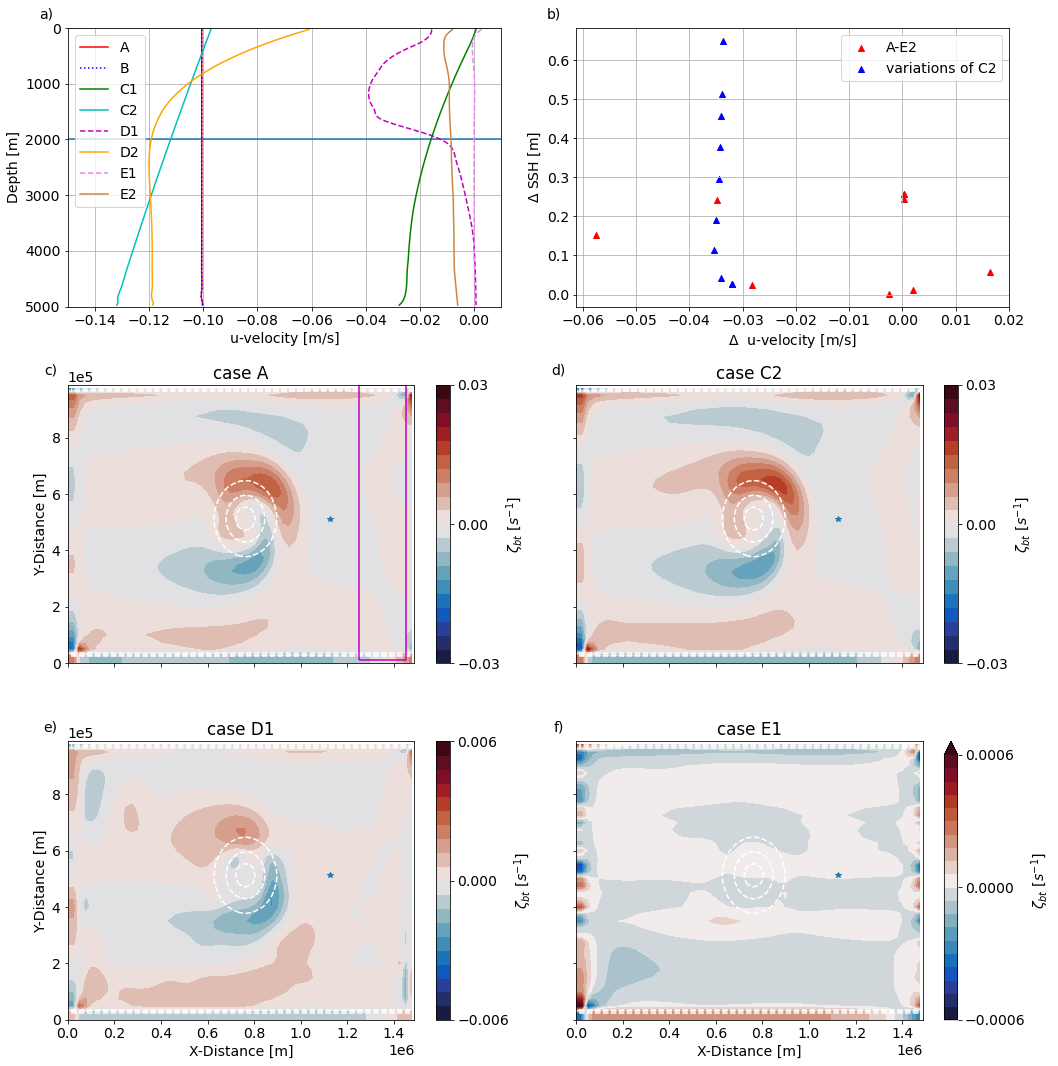

In [20]:
yy=20
xx=45
fig,axes = plt.subplots(3,2,figsize=(15,15))
ax=axes[0,0]
dsbb.U.isel(T=-1,X_left=xx,Y=yy).plot(y="Z",color='r',label="A",ax=ax)
dsb2u.U.isel(T=-1,X_left=xx,Y=yy).plot(y="Z",color='b',label="B",ax=ax,ls=':')
dsb2t.U.isel(T=-1,X_left=xx,Y=yy).plot(y="Z",color='g',label="C1",ax=ax)
dsb2tu010.U.isel(T=-1,X_left=xx,Y=yy).plot(y="Z",color='c',label="C2",ax=ax)
dsbet.U.isel(T=-1,X_left=xx,Y=yy).plot(y="Z",color='m',label="D1",ls='--',ax=ax)
dsbetu.U.isel(T=-1,X_left=xx,Y=yy).plot(y="Z",color='orange',label="D2",ax=ax)
dsbrt.U.isel(T=-1,X_left=xx,Y=yy).plot(y="Z",color='violet',label="E1",ls='--',ax=ax)
dsbrtu.U.isel(T=-1,X_left=xx,Y=yy).plot(y="Z",color='peru',label="E2",ax=ax)
ax.set_ylim(0,5000)
ax.invert_yaxis()
ax.hlines(y=2000,xmin=-0.15,xmax=0.01)
ax.set_xlim(-0.15,0.01)
ax.legend()
ax.grid()
ax.set_ylabel('Depth [m]')
ax.set_xlabel('u-velocity [m/s]')
ax.set_title('')#f'X={dsbrtu.X_left.isel(X_left=xx).data},Y={dsbrtu.Y.isel(Y=yy).data}')
ax.text(-0.05, 1.05, 'a)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

ax=axes[0,1]
ax.scatter(delu_A,sshmax_A,marker='^',color='r',label='A-E2')
ax.scatter(delu_C201,sshmax_C201,marker='^',color='b',label='variations of C2')
#plt.scatter(dsbb.U.isel(T=-1,X_left=xx,Y=20,Z=99).values,sshmax_A,marker='o',color='r',label="near bottom -4975m")
#plt.scatter(dsbb.U.isel(T=-1,X_left=xx,Y=20,Z=40).values,sshmax_A,marker='x',color='b',label="near top - 2025m")
#plt.scatter(dsbb.U.isel(T=-1,X_left=xx,Y=20,Z=0).values,sshmax_A,marker='^',color='c',label="surface - 25m")

# surface
ax.scatter(delu_A,sshmax_A,marker='^',color='r')
ax.scatter(delu_B,sshmax_B,marker='^',color='r')
ax.scatter(delu_C1,sshmax_C1,marker='^',color='r')
ax.scatter(delu_C2,sshmax_C2,marker='^',color='r')
ax.scatter(delu_D1,sshmax_D1,marker='^',color='r')
ax.scatter(delu_D2,sshmax_D2,marker='^',color='r')
ax.scatter(delu_E1,sshmax_E1,marker='^',color='r')
ax.scatter(delu_E2,sshmax_E2,marker='^',color='r')

ax.scatter(delu_C201,sshmax_C201,marker='^',color='b')
ax.scatter(delu_C202,sshmax_C202,marker='^',color='b')
ax.scatter(delu_C205,sshmax_C205,marker='^',color='b')
ax.scatter(delu_C208,sshmax_C208,marker='^',color='b')
ax.scatter(delu_C212,sshmax_C212,marker='^',color='b')
ax.scatter(delu_C215,sshmax_C215,marker='^',color='b')
ax.scatter(delu_C218,sshmax_C218,marker='^',color='b')
ax.scatter(delu_C220,sshmax_C220,marker='^',color='b')
ax.scatter(delu_C225,sshmax_C225,marker='^',color='b')
ax.legend(bbox_to_anchor=[1,1])
ax.grid()
ax.set_ylabel('$\\Delta$ SSH [m]')
ax.set_xlabel('$\\Delta$  u-velocity [m/s]')
ax.text(-0.05, 1.05, 'b)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

ax=axes[1,0]
wmin=-.03
wmax=-1*wmin
cmap2=cmo.balance
lev=21
(dsbb.zeta_bt.isel(T=-1)-dsbb.zeta_bt.isel(T=-1,X_left=slice(50,59)).mean(dim='X_left')).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':'$\\zeta_{bt}$ [$s^{-1}$]','ticks':np.linspace(wmin,wmax,3)})
dsbb.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
ax.plot(dsb2tu010.X_left.isel(X_left=45),dsb2tu010.Y.isel(Y=20),marker='*')
ax.hlines(dsbb.Y.isel(Y=0),dsbb.X_left.isel(X_left=50),dsbb.X_left.isel(X_left=58),color='m')
ax.hlines(dsbb.Y.isel(Y=39),dsbb.X_left.isel(X_left=50),dsbb.X_left.isel(X_left=58),color='m')
ax.vlines(dsbb.X_left.isel(X_left=50),dsbb.Y.isel(Y=0),dsbb.Y.isel(Y=39),color='m')
ax.vlines(dsbb.X_left.isel(X_left=58),dsbb.Y.isel(Y=0),dsbb.Y.isel(Y=39),color='m')
ax.set_title(f'case A')
ax.set_xlabel('')
ax.set_ylabel('Y-Distance [m]')
ax.set_xticklabels('')
ax.ticklabel_format(axis='y', style='scientific', scilimits=[-4,4])
ax.text(-0.05, 1.05, 'c)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

ax=axes[1,1]
(dsb2tu010.zeta_bt.isel(T=-1)-dsb2tu010.zeta_bt.isel(T=-1,X_left=slice(50,59)).mean(dim='X_left')).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':'$\\zeta_{bt}$ [$s^{-1}$]','ticks':np.linspace(wmin,wmax,3)})
dsbb.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
ax.plot(dsb2tu010.X_left.isel(X_left=45),dsb2tu010.Y.isel(Y=20),marker='*')
ax.set_title(f'case C2')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.text(-0.05, 1.05, 'd)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

ax=axes[2,0]
wmin=wmin/5
wmax=wmax/5
(dsbet.zeta_bt.isel(T=-1)-dsbet.zeta_bt.isel(T=-1,X_left=slice(50,59)).mean(dim='X_left')).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':'$\\zeta_{bt}$ [$s^{-1}$]','ticks':np.linspace(wmin,wmax,3)})
dsbet.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
ax.plot(dsb2tu010.X_left.isel(X_left=45),dsb2tu010.Y.isel(Y=20),marker='*')
ax.set_title(f'case D1')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('Y-Distance [m]')
ax.ticklabel_format(axis='y', style='scientific', scilimits=[-4,4])
ax.text(-0.05, 1.05, 'e)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

ax=axes[2,1]
wmin=wmin/10
wmax=-1*wmin
(dsbrt.zeta_bt.isel(T=-1)-dsbrt.zeta_bt.isel(T=-1,X_left=slice(50,59)).mean(dim='X_left')).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'extend':'neither','label':'$\\zeta_{bt}$ [$s^{-1}$]','ticks':np.linspace(wmin,wmax,3)})
dsbrt.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
ax.plot(dsb2tu010.X_left.isel(X_left=45),dsb2tu010.Y.isel(Y=20),marker='*')
ax.set_title(f'case E1')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.text(-0.05, 1.05, 'f)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)



plt.tight_layout()
plt.savefig('figures/U_zeta_baro_withoutGM.jpg',dpi=300)